In [1]:
from SimPEG import *
from simpegEM1D import EM1D, EM1DSurveyTD, Utils1D, get_vertical_discretization_time, set_mesh_1d, piecewise_pulse
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from simpegEM1D import skytem_HM_2015, skytem_LM_2015
wave_HM = skytem_HM_2015()
wave_LM = skytem_LM_2015()
time_HM = wave_HM.time_gate_center
time_LM = wave_LM.time_gate_center
def get_problem_survey(hz):
    mesh1D = set_mesh_1d(hz)
    depth = -mesh1D.gridN[:-1]
    LocSigZ = -mesh1D.gridCC
    expmap = Maps.ExpMap(mesh1D)    
    
    time_input_currents_HM = wave_HM.current_times[-7:]
    input_currents_HM = wave_HM.currents[-7:]
    time_input_currents_LM = wave_LM.current_times[-13:]
    input_currents_LM = wave_LM.currents[-13:]

    TDsurvey = EM1DSurveyTD(
        rx_location = np.array([0., 0., 100.+30.]),
        src_location = np.array([0., 0., 100.+30.]),
        topo = np.r_[0., 0., 100.],
        depth = depth,
        rx_type = 'dBzdt',
        wave_type = 'general',
        src_type = 'CircularLoop',
        a = 13.,
        I = 1.,
        time = time_HM,
        time_input_currents=time_input_currents_HM,
        input_currents=input_currents_HM,
        n_pulse = 2,
        base_frequency = 25.,
        use_lowpass_filter=True,
        high_cut_frequency=210*1e3,
        moment_type='dual',
        time_dual_moment = time_HM,    
        time_input_currents_dual_moment=time_input_currents_LM,
        input_currents_dual_moment=input_currents_LM,
        base_frequency_dual_moment=210,    
    )
    
    prob = EM1D(mesh1D, sigmaMap=expmap, verbose=False)
    if prob.ispaired:
        prob.unpair()
    if TDsurvey.ispaired:
        TDsurvey.unpair()
    prob.pair(TDsurvey)
    prob.chi = np.zeros(TDsurvey.n_layer)
    return TDsurvey, prob

In [3]:
hz = np.r_[100, 30, 180, 1000.]
sig = np.r_[1./50, 1./5, 1./30, 1./1.]
mesh1D = set_mesh_1d(hz)
depth = -mesh1D.gridN[:-1]
LocSigZ = -mesh1D.gridCC

In [4]:
TDsurvey, prob = get_problem_survey(hz)
sig_half = 1./50.
chi_half = 0.
m_true = np.log(sig)
std = 0.05
dtrue = TDsurvey.dpred(m_true)
np.random.seed(1)
noise = std*abs(dtrue)*np.random.randn(*dtrue.shape)
dobs = dtrue+noise

In [5]:
import matplotlib
matplotlib.rcParams['font.size'] = 14

(-600, 0)

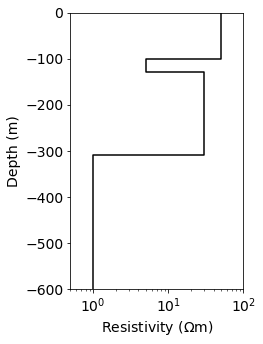

In [6]:
fig, ax = subplots(1,1, figsize=(4, 5))
Utils1D.plotLayer(1./sig, mesh1D, showlayers=False, ax=ax)
ax.set_xlabel("Resistivity ($\Omega$m)")
plt.tight_layout()
fig.savefig('resistivity', dpi=200)
ax.set_xlim(0.5, 100)
ax.set_ylim(-600, 0)

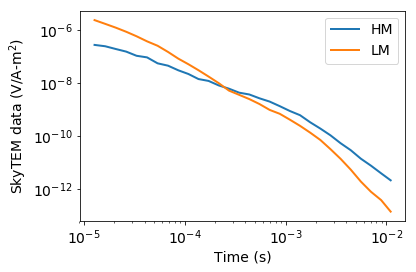

In [7]:
fig, axes = subplots(1,1, figsize = (6,4))
axes.plot(TDsurvey.time, -dobs[:TDsurvey.n_time], '-', lw=2)
axes.plot(TDsurvey.time_dual_moment, -dobs[TDsurvey.n_time:], '-', lw=2)
axes.set_xscale('log');
axes.set_yscale('log');
plt.legend(("HM", "LM"))
plt.xlabel("Time (s)")
plt.ylabel("SkyTEM data (V/A-m$^2$)")
plt.tight_layout()
fig.savefig('skytem_data', dpi=200)

In [8]:
# std = 0.05
# prob.getJ(m_true)
# prob.depth_of_investigation_christiansen_2012(std, thres_hold=0.8)

In [9]:
IRLS = Directives.Update_IRLS(
        maxIRLSiter=40, minGNiter=1, fix_Jmatrix=True, coolingRate=1, coolingFactor=2, betaSearch=False,
        chifact_start = 1.
    )

In [10]:
def run_inversion(m0, dobs, std, floor, is_sparse=True):
    hz = get_vertical_discretization_time(
        np.unique(np.r_[time_HM, time_LM]), facter_tmax=0.5, factor_tmin=10., n_layer=30
    )    
    mesh1D = set_mesh_1d(hz)
    TDsurvey, prob = get_problem_survey(hz)
    TDsurvey.dobs = dobs.copy()
    uncert = abs(TDsurvey.dobs)*std+floor
    dmisfit = DataMisfit.l2_DataMisfit(TDsurvey)
    dmisfit.W = 1./ uncert
    
    
    if is_sparse:
        reg = Regularization.Sparse(
            mesh1D,
            mapping=Maps.IdentityMap(mesh1D),
            alpha_s=1.,
            alpha_x=1.,
        )
        p = 0
        qx, qz = 1., 1.
        reg.norms = np.c_[p, qx, qz, 0.]
        IRLS = Directives.Update_IRLS(
            maxIRLSiter=40, minGNiter=1, fix_Jmatrix=True, coolingRate=1, coolingFactor=5, betaSearch=False,
            chifact_start = 1.,
            f_min_change = 1e-3
        )        
    else:
        reg = Regularization.Tikhonov(
            mesh1D,
            mapping=Maps.IdentityMap(mesh1D),
            alpha_s=1.,
            alpha_x=0.05,
        )        
    opt = Optimization.ProjectedGNCG(maxIter = 40)
    invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
    beta = Directives.BetaSchedule(coolingFactor=2., coolingRate=1)
    betaest = Directives.BetaEstimate_ByEig(beta0_ratio=10**1.5)
    target = Directives.TargetMisfit()
    save = Directives.SaveOutputEveryIteration()
    if is_sparse:
        directiveList=[IRLS, betaest]
    else:
        directiveList=[beta, betaest, target]
    
    inv = Inversion.BaseInversion(invProb, directiveList=directiveList)
    prob.counter = opt.counter = Utils.Counter()
    opt.LSshorten = 0.5
    opt.remember('xc')
    mopt = inv.run(m0)
    return mopt, invProb

In [11]:
%%time
m0 = np.log(np.ones(30)*1./50)
mopt, invProb = run_inversion(m0, dobs, 0.1, 0., is_sparse=False)

SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  8.07e+01  5.09e+02  0.00e+00  5.09e+02    1.66e+02      0              
   1  4.03e+01  4.88e+02  1.23e-01  4.93e+02    8.56e+01      0              
   2  2.02e+01  4.67e+02  4.87e-01  4.77e+02    8.70e+01      0   Skip BFGS  
   3  1.01e+01  4.28e+02  1.85e+00  4.46e+02    9.27e+01      0              
   4  5.04e+00  3.51e+02  6.80e+00  3.85e+02    1.03e+02      0              
   5  2.52e

In [12]:
m0_1 = np.log(np.ones(30)*1./30)
mopt_1, invProb_1 = run_inversion(m0_1, dobs, 0.1, 0., is_sparse=False)

SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.13e+02  1.26e+03  0.00e+00  1.26e+03    1.65e+03      0              
   1  1.06e+02  5.15e+02  1.25e+00  6.48e+02    2.97e+02      0              
   2  5.32e+01  3.94e+02  2.14e+00  5.07e+02    2.33e+02      0   Skip BFGS  
   3  2.66e+01  2.90e+02  3.62e+00  3.86e+02    1.54e+02      0   Skip BFGS  
   4  1.33e+01  2.20e+02  5.60e+00  2.94e+02    1.08e+02      0   Skip BFGS  
   5  6.64e

In [13]:
def compute_doi_index_oldenburg_and_li_1999(m1, m2, m1r, m2r):
    r = abs((m1-m2) / (m1r-m2r))
    r[r>0.99] = 1.
    return r

In [14]:
# fig, ax = subplots(1,1, figsize=(4, 5))
# Utils1D.plotLayer(1./sig, mesh1D, showlayers=False, ax=ax)
# Utils1D.plotLayer(1./(expmap*invProb.l2model), mesh1D, showlayers=False, **{'color':'r', 'lw':3})
# ax.set_xlabel("Resistivity ($\Omega$m)")
# ax.set_xlim(0.5, 300)
# plt.tight_layout()
# fig.savefig('resistivity_l2', dpi=200)

In [15]:
mesh1D_inv = invProb.dmisfit.prob.mesh

In [18]:
# fig, ax = subplots(1,1, figsize=(4, 5))
# Utils1D.plotLayer(1./sig, mesh1D, showlayers=False, ax=ax)
# Utils1D.plotLayer(1./(np.log(mopt)), mesh1D_inv, showlayers=False, **{'color':'r', 'lw':3})
# ax.set_xlabel("Resistivity ($\Omega$m)")
# ax.set_xlim(0.5, 300)
# ax.set_ylim(-600, 0)
# plt.tight_layout()
# fig.savefig('resistivity_l2', dpi=200)


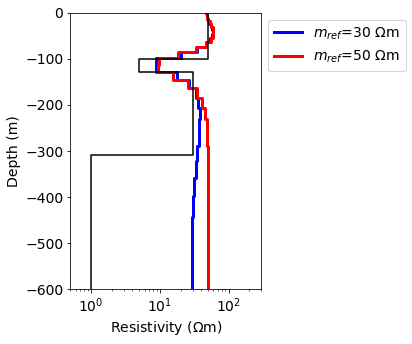

In [26]:
fig, ax = subplots(1,1, figsize=(4, 5))
Utils1D.plotLayer(1./(np.exp(mopt_1)), mesh1D_inv, showlayers=False, **{'color':'b', 'lw':3})
Utils1D.plotLayer(1./(np.exp(mopt)), mesh1D_inv, showlayers=False, **{'color':'r', 'lw':3})
Utils1D.plotLayer(1./sig, mesh1D, showlayers=False, ax=ax)
ax.set_xlabel("Resistivity ($\Omega$m)")
ax.set_xlim(0.5, 300)
ax.set_ylim(-600, 0)
plt.tight_layout()
ax.legend(("$m_{ref}$=30 $\Omega$m", "$m_{ref}$=50 $\Omega$m"), bbox_to_anchor=(1,1))

fig.savefig('resistivity_l2_compare', dpi=200)


In [23]:
m0 = np.log(np.ones(30)*1./50)
mopt_sparse, invProb_sparse = run_inversion(m0, dobs, 0.1, 0., is_sparse=True)

SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***


/Users/sgkang/Projects/simpeg/SimPEG/Directives.py:935: UserWarning: Without a Linear preconditioner, convergence may be slow. Consider adding `Directives.UpdatePreconditioner` to your directives list
  "Without a Linear preconditioner, convergence may be slow. "


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.18e+01  5.09e+02  0.00e+00  5.09e+02    1.66e+02      0              
   1  1.04e+01  4.78e+02  2.75e-01  4.81e+02    1.34e+02      0              
   2  2.07e+00  3.73e+02  5.34e+00  3.84e+02    1.47e+02      0   Skip BFGS  
   3  4.14e-01  8.46e+01  5.55e+01  1.08e+02    1.00e+02      0              
   4  8.28e-02  3.45e+01  9.60e+01  4.25e+01    1.05e+02      0              
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 1.9904416499072104 eps_q: 1.9904416499072104
>> Fix Jmatrix
delta phim:    inf
   5  1.66e-02  1.99e+01  1.35e+02  2.22e+01    5.66e+01      0              
>> Fix Jmatrix
delta phim: 6.784e-01
   6  3.18e-02  1.63e+01  1.68e+02  2.17e+01    1.33e+01     

In [24]:
m0_1 = np.log(np.ones(30)*1./30)
mopt_sparse_1, invProb_sparse_1 = run_inversion(m0_1, dobs, 0.1, 0., is_sparse=True)

SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.36e+02  1.26e+03  0.00e+00  1.26e+03    1.65e+03      0              
   1  2.73e+01  4.39e+02  1.83e+00  4.89e+02    4.39e+02      0              
   2  5.46e+00  2.27e+02  5.62e+00  2.57e+02    1.81e+02      0   Skip BFGS  
   3  1.09e+00  1.07e+02  1.59e+01  1.25e+02    9.05e+01      0   Skip BFGS  
   4  2.18e-01  4.34e+01  4.00e+01  5.21e+01    3.24e+01      0   Skip BFGS  
Reached sta

In [28]:
# fig, ax = subplots(1,1, figsize=(4, 5))
# Utils1D.plotLayer(1./sig, mesh1D, showlayers=False, ax=ax)
# Utils1D.plotLayer(1./(expmap*mopt_sparse), mesh1D_inv, showlayers=False, **{'color':'r', 'lw':3})
# ax.set_xlabel("Resistivity ($\Omega$m)")
# ax.set_xlim(0.5, 300)
# ax.set_ylim(-600, 0)
# plt.tight_layout()
# fig.savefig('resistivity_l0', dpi=200)


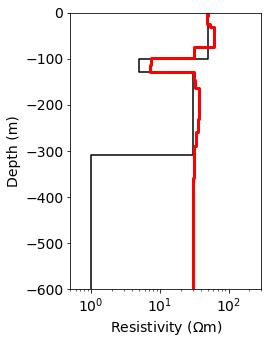

In [30]:
fig, ax = subplots(1,1, figsize=(4, 5))
Utils1D.plotLayer(1./sig, mesh1D, showlayers=False, ax=ax)
Utils1D.plotLayer(1./(np.exp(mopt_sparse_1)), mesh1D_inv, showlayers=False, **{'color':'r', 'lw':3})
ax.set_xlabel("Resistivity ($\Omega$m)")
ax.set_xlim(0.5, 300)
ax.set_ylim(-600, 0)
plt.tight_layout()
fig.savefig('resistivity_l0', dpi=200)


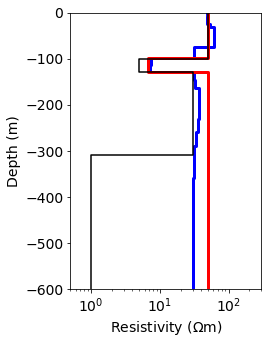

In [32]:
fig, ax = subplots(1,1, figsize=(4, 5))
Utils1D.plotLayer(1./(np.exp(mopt_sparse_1)), mesh1D_inv, showlayers=False, **{'color':'b', 'lw':3})
Utils1D.plotLayer(1./(np.exp(mopt_sparse)), mesh1D_inv, showlayers=False, **{'color':'r', 'lw':3})
# ax.legend(("$m_{ref}$=30 $\Omega$m", "$m_{ref}$=50 $\Omega$m"), bbox_to_anchor=(1,1))
Utils1D.plotLayer(1./sig, mesh1D, showlayers=False, ax=ax)
ax.set_xlabel("Resistivity ($\Omega$m)")
ax.set_xlim(0.5, 300)
ax.set_ylim(-600, 0)
plt.tight_layout()
fig.savefig('resistivity_l0_compare', dpi=200)


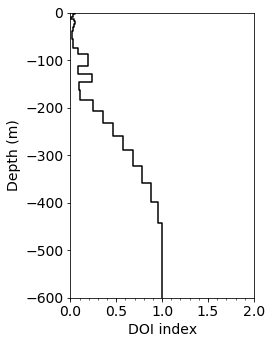

In [35]:
fig, ax = subplots(1,1, figsize=(4, 5))
doi = compute_doi_index_oldenburg_and_li_1999(mopt, mopt_1, m0, m0_1)
Utils1D.plotLayer(doi, mesh1D_inv, showlayers=False, xscale='linear', ax=ax)
# Utils1D.plotLayer(doi_sparse, mesh1D_inv, showlayers=False, xscale='linear', **{'linestyle':'--', 'color':'k'})
ax.set_xticks(np.arange(20)*0.1, minor=True)
ax.set_xlabel("DOI index")
# ax.legend(("L2", "L0"))
ax.set_ylim(-600, 0)
plt.tight_layout()
fig.savefig('doi_index', dpi=200)

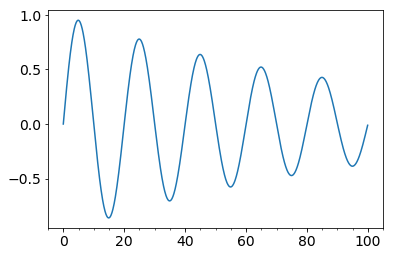

In [732]:
majorLocator = MultipleLocator(20)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(5)
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
# for the minor ticks, use no labels; default NullFormatter
ax.xaxis.set_minor_locator(minorLocator)

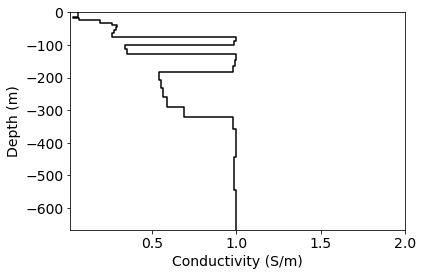

In [719]:
doi_sparse = compute_doi_index_oldenburg_and_li_1999(mopt_sparse, mopt_sparse_1, m0, m0_1)


In [711]:
doi_sparse

array([ 0.05995581,  0.06270161,  0.06043333,  0.03152822, -0.06894506,
       -0.19037729, -0.26253323, -0.28956682, -0.28484674, -0.27410856,
       -0.26178366,  1.05977935,  0.98591186, -0.34108015, -0.35094573,
        2.02869894,  0.98994558,  0.98033542,  0.54059936,  0.55051647,
        0.56730828,  0.58770533,  0.69061336,  0.98243134,  1.        ,
        1.        ,  0.98822796,  0.98290827,  1.03937674,  1.18322866])

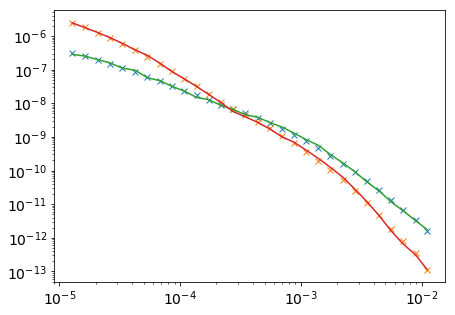

In [312]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(TDsurvey.time, -invProb.dpred[:TDsurvey.n_time], 'x')
axes.plot(TDsurvey.time_dual_moment, -invProb.dpred[TDsurvey.n_time:], 'x')
axes.plot(TDsurvey.time, -dobs[:TDsurvey.n_time])
axes.plot(TDsurvey.time_dual_moment, -dobs[TDsurvey.n_time:])

axes.set_xscale('log');
axes.set_yscale('log');